# Import g-drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
root_path  = 'gdrive/My Drive/ho/hyperlearning/batch-size/experiments'


Mounted at /content/gdrive/


GPU info

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 10 09:00:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# dataset.py

In [3]:

import os 
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_loc = '/data'

def get_dataloaders(dataset, batch_size, train_percent=0.8):
  if dataset == 'mnist':
      return mnist_data_loader(batch_size, train_percent)
  elif dataset == 'svhn':
      return svhn_data_loader(batch_size, train_percent)
  elif dataset == 'cifar_10':
      return cifar_10_data_loader(batch_size, train_percent)
  elif dataset == 'cifar_100':
      return cifar_100_data_loader(batch_size, train_percent)
  else:
      raise Exception('dataset is not supported')

def mnist_data_loader(batch_size, train_percent):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  
  ''' datasets
  '''
  train_dataset = datasets.MNIST(root=data_loc, train=True, download=True, transform=transform)
  test_dataset = datasets.MNIST(root=data_loc, train=False, transform=transform, )
  
  ''' dataloaders 
  '''
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(train_percent * num_train))
  # training
  train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
    pin_memory=False, num_workers=1) 
  # validation data
  val_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
    pin_memory=False, num_workers=1)
  # test data 
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)

  custom_loader = CustomDataLoader_mnist(train_dataset, transform, train_percent)

  return {'train':train_loader, 'val':val_loader, 'test':test_loader, 'custom':custom_loader}
  
def svhn_data_loader(batch_size, train_percent):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  
  ''' datasets
  '''
  train_dataset = datasets.SVHN(root=data_loc, split='train', download=True, transform=transform)
  test_dataset = datasets.SVHN(root=data_loc, split='test', download=True, transform=transform)

  ''' dataloaders 
  '''
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(train_percent * num_train))
  # training
  train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
    pin_memory=False, num_workers=1) 
  # validation data
  val_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
    pin_memory=False, num_workers=1)
  # test data 
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)

  # custom_loader = CustomDataLoader(train_dataset, transform, train_percent)

  return {'train':train_loader, 'val':val_loader, 'test':test_loader}
  # return {'train':train_loader, 'val':val_loader, 'test':test_loader, 'custom':custom_loader}
  
def cifar_10_data_loader(batch_size, train_percent, hessian_data=True):
  # transforms
  transform_train = transforms.Compose(
      [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ])
  transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(
      (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ])
  
  # datasets
  train_dataset = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=transform_train)
  test_dataset = datasets.CIFAR10(root=data_loc, train=False, transform=transform_test)
  
  # dataloaders with validation/hessian subsets of the training dataset
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(train_percent * num_train))

  # Choice to set aside a small % of training data for Hessian analysis (e.g. 5%=2500 of CIFAR10 is standard)
  if hessian_data:
    # 37500 training images
    train_loader = DataLoader(
      train_dataset, batch_size=batch_size,
      sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:(split-2500)]), 
      pin_memory=True, num_workers=1)  # validation data
    
    # 2500 training for hessian
    hessian_loader = DataLoader(
      train_dataset, batch_size=500,
      sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[(split-2500):split]),
      pin_memory=True, num_workers=1)  

    # 10000 valdation data
    val_loader = DataLoader(
      train_dataset, batch_size=batch_size,
      sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
      pin_memory=True, num_workers=1)

    # test data 
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)

    return {'hessian':hessian_loader, 'train':train_loader, 'val':val_loader, 'test':test_loader}
  
  else:
    # pull out 2500 from 40000 and use as hessian dataset
    train_loader = DataLoader(
      train_dataset, batch_size=batch_size,
      sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:(split)]),
      pin_memory=True, num_workers=1)  # validation data

    # validation data
    val_loader = DataLoader(
      train_dataset, batch_size=batch_size,
      sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
      pin_memory=True, num_workers=1)

    # test data 
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)

    return {'train':train_loader, 'val':val_loader, 'test':test_loader}
  

  # train_loader = DataLoader(
  #   train_dataset, batch_size=batch_size,
  #   sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
  #   pin_memory=False, num_workers=1) 
 
  # # validation data
  # val_loader = DataLoader(
  #   train_dataset, batch_size=batch_size,
  #   sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
  #   pin_memory=False, num_workers=1)

  # # test data 
  # test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)

  # # custom_loader = CustomDataLoader(train_dataset, transform_train, train_percent)

  # return {'train':train_loader, 'val':val_loader, 'test':test_loader, 'custom':custom_loader}
  

def cifar_100_data_loader(batch_size, train_percent):
  transform_train = transforms.Compose(
      [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)), ])
  transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(
      (0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)), ])
  
  '''datasets '''
  train_dataset = datasets.CIFAR100(root=data_loc, train=True, download=True, transform=transform_train)
  test_dataset = datasets.CIFAR100(root=data_loc, train=False, transform=transform_test)

  ''' dataloaders '''
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(train_percent * num_train))

  train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
    pin_memory=True, num_workers=1) 

  # validation data
  val_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
    pin_memory=True, num_workers=1)

  # test data 
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)
  
  custom_loader = CustomDataLoader(train_dataset, transform_train, train_percent)

  return {'train':train_loader, 'val':val_loader, 'test':test_loader, 'custom':custom_loader}
  

# custom_dataloader.py

In [4]:


'''
@started: 17/11/21
@author: calmac
'''

import os 
import numpy as np
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils import data 

class CustomDataLoader(object):
  
    def __init__(self, dataset, transform, split):

        self.num_train = len(dataset)
        self.val_start = int(np.floor(split * self.num_train))
        self.data = dataset.data
        self.targets = dataset.targets
        self.transform = transform

    def __call__(self, sample_size):

        
        idx = list(np.random.randint(low=self.val_start, high=self.num_train, size=sample_size))
        
        X = np.array([self.data[i] for i in idx])
        labels = torch.from_numpy(np.array([self.targets[i] for i in idx]))

        for i in range(sample_size):
          xi = Image.fromarray(X[i,:])
          xi = self.transform(xi).unsqueeze(0)
          if i==0:
            inputs = xi
          else:
            inputs = torch.cat((inputs,xi), dim=0)

        return inputs, labels



# pyhessian.py

In [ ]:
import torch
import math
from torch.autograd import Variable
import torch.autograd as ag
import numpy as np

def group_product(xs, ys):
    """
    the inner product of two lists of variables xs,ys
    :param xs:
    :param ys:
    :return:
    """
    return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])


def group_add(params, update, alpha=1):
    """
    params = params + update*alpha
    :param params: list of variable
    :param update: list of data
    :return:
    """
    for i, p in enumerate(params):
        params[i].data.add_(update[i] * alpha)
    return params


def normalization(v):
    """
    normalization of a list of vectors
    return: normalized vectors v
    """
    s = group_product(v, v)
    s = s**0.5
    s = s.cpu().item()
    v = [vi / (s + 1e-6) for vi in v]
    return v


def get_params_grad(model):
    """
    get model parameters and corresponding gradients
    """
    params = []
    grads = []
    for param in model.parameters():
        if not param.requires_grad:
            continue
        params.append(param)
        grads.append(0. if param.grad is None else param.grad + 0.)
    return params, grads

def hessian_vector_product(gradsH, params, v):
    """
    compute the hessian vector product of Hv, where
    gradsH is the gradient at the current point,
    params is the corresponding variables,
    v is the vector.
    """
    hv = ag.grad(gradsH,
                        params,
                        grad_outputs=v,
                        only_inputs=True,
                        retain_graph=True)
    return hv


def orthnormal(w, v_list):
    """
    make vector w orthogonal to each vector in v_list.
    afterwards, normalize the output w
    """
    for v in v_list:
        w = group_add(w, v, alpha=-group_product(w, v))
    return normalization(w)

def zero_grads(model, set_to_none=False):
    ''' same function as .zero_grad() from pytorch.
        hacked slightly to avoid errors by using .detach() instead of .detach_()
    '''
    for p in model.parameters():
      if p.grad is not None:
          if set_to_none:
              p.grad = None
          else:
              if p.grad.grad_fn is not None:
                  p.grad.detach()
              else:
                  p.grad.requires_grad_(False)
              p.grad.zero_()

class hessian():
    """
    The class used to compute :
        i) the top 1 (n) eigenvalue(s) of the neural network
        ii) the trace of the entire neural network
        iii) the estimated eigenvalue density
    """

    def __init__(self, model, criterion, likelihood=None, data=None, dataloader=None, cuda=True, dkl=False):
        """
        model: the model that needs Hessain information
        criterion: the loss function
        data: a single batch of data, including inputs and its corresponding labels
        dataloader: the data loader including bunch of batches of data
        """

        # make sure we either pass a single batch or a dataloader
        assert (data != None and dataloader == None) or (data == None and
                                                         dataloader != None)

        self.model = model.eval()  # make model is in evaluation model
        self.n_params = count_params(self.model)
        self.criterion = criterion

        # minibatch of data
        if data != None:
            self.data = data
            self.full_dataset = False
        else:
            self.data = dataloader
            self.full_dataset = True

        if cuda:
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        # pre-processing for single batch case to simplify the computation.
        if not self.full_dataset:
            self.inputs, self.targets = self.data
            if self.device == 'cuda':
                self.inputs, self.targets = self.inputs.cuda(
                ), self.targets.cuda()

            # if we only compute the Hessian information for a single batch data, we can re-use the gradients.
            outputs = self.model(self.inputs)
            loss = self.criterion(outputs, self.targets)
            # loss.backward(create_graph=True)
            ''' added these next lines to avoid memory leak problem with .backward()
            '''
            grads = ag.grad(loss, self.model.parameters(), create_graph=True)
            for p, g in zip(self.model.parameters(), grads):
                p.grad = g
                                     
        # this step is used to extract the parameters and grads from the model
        self.params, self.gradsH = get_params_grad(self.model)
        
    def dataloader_hv_product(self, v):

        device = self.device
        num_data = 0  # count the number of datum points in the dataloader

        THv = [torch.zeros(p.size()).to(device) for p in self.params
              ]  # accumulate result
              
        for i, (inputs, targets) in enumerate(self.data):
          self.model.zero_grad()
          tmp_num_data = inputs.size(0)
          outputs = self.model(inputs.to(device))
          loss = self.criterion(outputs, targets.to(device))
          loss.backward(create_graph=True)
          params, gradsH = get_params_grad(self.model)
          self.model.zero_grad()
          Hv = torch.autograd.grad(gradsH,
                                    params,
                                    grad_outputs=v,
                                    only_inputs=True,
                                    retain_graph=False)
          THv = [
              THv1 + Hv1 * float(tmp_num_data) + 0.
              for THv1, Hv1 in zip(THv, Hv)
          ]
          num_data += float(tmp_num_data)
        
        THv = [THv1 / float(num_data) for THv1 in THv]
        eigenvalue = group_product(THv, v).cpu().item()
        return eigenvalue, THv

    

    def _minibatch_hv_dnn(self, v):
        self.model.zero_grad()
        outputs = self.model(self.inputs)
        loss = self.criterion(outputs, self.targets)
        loss.backward(create_graph=True)
        params, gradsH = get_params_grad(self.model)
        self.model.zero_grad()
        Hv = torch.autograd.grad(gradsH,
                                  params,
                                  grad_outputs=v,
                                  only_inputs=True,
                                  retain_graph=False)
        return Hv

  


    def eigenvalues(self, maxIter=100, tol=1e-3, top_n=1):
        """
        compute the top_n eigenvalues using power iteration method
        maxIter: maximum iterations used to compute each single eigenvalue
        tol: the relative tolerance between two consecutive eigenvalue computations from power iteration
        top_n: top top_n eigenvalues will be computed
        """
      
        assert top_n >= 1

        device = self.device

        eigenvalues = []
        eigenvectors = []

        computed_dim = 0

        while computed_dim < top_n:
            eigenvalue = None
            v = [torch.randn(p.size()).to(device) for p in self.params
                ]  # generate random vector
            v = normalization(v)  # normalize the vector

            for i in range(maxIter):
                v = orthnormal(v, eigenvectors)
                zero_grads(self.model)
                
                print('computing hvp...')
                if self.full_dataset:
                    tmp_eigenvalue, Hv = self.dataloader_hv_product(v)
                else:
                    Hv = hessian_vector_product(self.gradsH, self.params, v)
                    tmp_eigenvalue = group_product(Hv, v).cpu().item()
                    # Hf = tmp_eigenvalue / self.n_params 
                    '''Frobenius norm of the Hessian (i.e. magnitude), divided by # params: see Three-factors paper'''
                    Hf = torch.sqrt(group_product(Hv, Hv)) / self.n_params 

                v = normalization(Hv)

                if eigenvalue == None:
                    eigenvalue = tmp_eigenvalue
                else:
                    if abs(eigenvalue - tmp_eigenvalue) / (abs(eigenvalue) +
                                                           1e-6) < tol:
                        break
                    else:
                        eigenvalue = tmp_eigenvalue
            eigenvalues.append(eigenvalue)
            eigenvectors.append(v)
            computed_dim += 1
                        
        # zero_grads(self.model)

        return eigenvalues, eigenvectors, Hf

    def trace(self, maxIter=100, tol=1e-3):
        """
        compute the trace of hessian using Hutchinson's method
        maxIter: maximum iterations used to compute trace
        tol: the relative tolerance
        """

        device = self.device
        trace_vhv = []
        trace = 0.

        for i in range(maxIter):
            self.model.zero_grad()
            v = [
                torch.randint_like(p, high=2, device=device)
                for p in self.params
            ]
            # generate Rademacher random variables
            for v_i in v:
                v_i[v_i == 0] = -1

            if self.full_dataset:
                _, Hv = self.dataloader_hv_product(v)
            else:
                Hv = hessian_vector_product(self.gradsH, self.params, v)
            trace_vhv.append(group_product(Hv, v).cpu().item())
            if abs(np.mean(trace_vhv) - trace) / (trace + 1e-6) < tol:
                return trace_vhv
            else:
                trace = np.mean(trace_vhv)

        return trace_vhv

    def density(self, iter=100, n_v=1):
        """
        compute estimated eigenvalue density using stochastic lanczos algorithm (SLQ)
        iter: number of iterations used to compute trace
        n_v: number of SLQ runs
        """

        device = self.device
        eigen_list_full = []
        weight_list_full = []

        for k in range(n_v):
            v = [
                torch.randint_like(p, high=2, device=device)
                for p in self.params
            ]
            # generate Rademacher random variables
            for v_i in v:
                v_i[v_i == 0] = -1
            v = normalization(v)

            # standard lanczos algorithm initlization
            v_list = [v]
            w_list = []
            alpha_list = []
            beta_list = []
            ############### Lanczos
            for i in range(iter):
                self.model.zero_grad()
                w_prime = [torch.zeros(p.size()).to(device) for p in self.params]
                if i == 0:
                    if self.full_dataset:
                        _, w_prime = self.dataloader_hv_product(v)
                    else:
                        w_prime = hessian_vector_product(
                            self.gradsH, self.params, v)
                    alpha = group_product(w_prime, v)
                    alpha_list.append(alpha.cpu().item())
                    w = group_add(w_prime, v, alpha=-alpha)
                    w_list.append(w)
                else:
                    beta = torch.sqrt(group_product(w, w))
                    beta_list.append(beta.cpu().item())
                    if beta_list[-1] != 0.:
                        # We should re-orth it
                        v = orthnormal(w, v_list)
                        v_list.append(v)
                    else:
                        # generate a new vector
                        w = [torch.randn(p.size()).to(device) for p in self.params]
                        v = orthnormal(w, v_list)
                        v_list.append(v)
                    if self.full_dataset:
                        _, w_prime = self.dataloader_hv_product(v)
                    else:
                        w_prime = hessian_vector_product(
                            self.gradsH, self.params, v)
                    alpha = group_product(w_prime, v)
                    alpha_list.append(alpha.cpu().item())
                    w_tmp = group_add(w_prime, v, alpha=-alpha)
                    w = group_add(w_tmp, v_list[-2], alpha=-beta)

            T = torch.zeros(iter, iter).to(device)
            for i in range(len(alpha_list)):
                T[i, i] = alpha_list[i]
                if i < len(alpha_list) - 1:
                    T[i + 1, i] = beta_list[i]
                    T[i, i + 1] = beta_list[i]
            a_, b_ = torch.eig(T, eigenvectors=True)

            eigen_list = a_[:, 0]
            weight_list = b_[0, :]**2
            eigen_list_full.append(list(eigen_list.cpu().numpy()))
            weight_list_full.append(list(weight_list.cpu().numpy()))

        return eigen_list_full, weight_list_full


# hd.py

In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer,required
from functools import reduce


class SGDHD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).
    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        hypergrad_lr (float, optional): hypergradient learning rate for the online
        tuning of the learning rate, introduced in the paper
        `Online Learning Rate Adaptation with Hypergradient Descent`_
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf
    .. _Online Learning Rate Adaptation with Hypergradient Descent:
        https://openreview.net/forum?id=BkrsAzWAb
    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.
        Considering the specific case of Momentum, the update can be written as
        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v
        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.
        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form
        .. math::
             v = \rho * v + lr * g \\
             p = p - v
        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, hypergrad_lr=0, results_files=None):
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, hypergrad_lr=hypergrad_lr)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGDHD, self).__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError("SGDHD doesn't support per-parameter options (parameter groups)")

        self._params = self.param_groups[0]['params']
        self._params_numel = reduce(lambda total, p: total + p.numel(), self._params, 0)

        self.results_files = results_files

    def _gather_flat_grad_with_weight_decay(self, weight_decay=0):
        views = []
        for p in self._params:
            if p.grad is None:
                view = torch.zeros_like(p.data)
            elif p.grad.data.is_sparse:
                view = p.grad.data.to_dense().view(-1)
            else:
                view = p.grad.data.view(-1)
            if weight_decay != 0:
                view.add_(weight_decay, p.data.view(-1))
            views.append(view)
        return torch.cat(views, 0)

    def _add_grad(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))
            offset += numel
        assert offset == self._params_numel

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        assert len(self.param_groups) == 1

        loss = None
        if closure is not None:
            loss = closure()

        group = self.param_groups[0]
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']

        grad = self._gather_flat_grad_with_weight_decay(weight_decay)

        # NOTE: SGDHD has only global state, but we register it as state for
        # the first param, because this helps with casting in load_state_dict
        state = self.state[self._params[0]]
        # State initialization
        if len(state) == 0:
            state['grad_prev'] = torch.zeros_like(grad)

        grad_prev = state['grad_prev']
        # Hypergradient for SGD
        h = torch.dot(grad, grad_prev)
        # Hypergradient descent of the learning rate:
        group['lr'] += group['hypergrad_lr'] * h
        write_results('{}'.format(h.item()), self.results_files['h'])
        write_results('{}'.format(group['lr'].data), self.results_files['lrit'])

        if momentum != 0:
            if 'momentum_buffer' not in state:
                buf = state['momentum_buffer'] = torch.zeros_like(grad)
                buf.mul_(momentum).add_(grad)
            else:
                buf = state['momentum_buffer']
                buf.mul_(momentum).add_(1 - dampening, grad)
            if nesterov:
                grad.add_(momentum, buf)
            else:
                grad = buf

        state['grad_prev'] = grad

        self._add_grad(-group['lr'], grad)

        return loss


class AdamHD(Optimizer):
    """Implements Adam algorithm.

    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hypergrad_lr (float, optional): hypergradient learning rate for the online
        tuning of the learning rate, introduced in the paper
        `Online Learning Rate Adaptation with Hypergradient Descent`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Online Learning Rate Adaptation with Hypergradient Descent:
        https://openreview.net/forum?id=BkrsAzWAb
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, hypergrad_lr=1e-8, results_files=None):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, hypergrad_lr=hypergrad_lr)
        super(AdamHD, self).__init__(params, defaults)
        
        self.results_files = results_files

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                if state['step'] > 1:
                    prev_bias_correction1 = 1 - beta1 ** (state['step'] - 1)
                    prev_bias_correction2 = 1 - beta2 ** (state['step'] - 1)
                    # Hypergradient for Adam:
                    h = torch.dot(grad.view(-1), torch.div(exp_avg, exp_avg_sq.sqrt().add_(group['eps'])).view(-1)) * math.sqrt(prev_bias_correction2) / prev_bias_correction1
                    # Hypergradient descent of the learning rate:
                    group['lr'] += group['hypergrad_lr'] * h
                    write_results('{}'.format(h.item()), self.results_files['h'])
                    write_results('{}'.format(group['lr'].data), self.results_files['lrit'])
                
                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

# network.py

In [5]:
'''
@author: calmac
@started: 13/10/21

'''

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

def get_network(network_name, dataset):
    if dataset == 'mnist':
        return network(network_name, num_classes=10, num_channels=1)
    elif dataset == 'svhn':
        return network(network_name, num_classes=10, num_channels=3)
    elif dataset == 'cifar_10':
        return network(network_name, num_classes=10, num_channels=3)
    elif dataset == 'cifar_100':
        return network(network_name, num_classes=100, num_channels=3)
    else:
        raise Exception('dataset is not supported')


def network(network_name, num_classes, num_channels):
    # Wide ResNet
    if network_name == 'wrn':
        return wide_resnet_16_4(num_classes)  
    # VGG
    elif network_name == 'vgg':
        return vgg11_bn(num_classes)
    # MLP
    elif network_name == 'mlp':
        return mlp(num_classes, num_channels)
    # LeNet
    elif network_name == 'lenet':
        return lenet_5(num_classes, num_channels)
    else:
        raise Exception('network is not supported')


"""
===============================
Wide ResNets 
===============================
Reimplementation of https://github.com/meliketoy/wide-resnet.pytorch
"""

class WideResNet(nn.Module):

    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(WideResNet, self).__init__()

        self.in_planes = 16
        
        assert (int((depth - 4) % 6) == 0), 'Wide-resnet depth should be 6n+4'
        n = int((depth - 4) / 6)
        k = widen_factor

        n_stages = [16, 16 * k, 32 * k, 64 * k]

        self.conv1 = conv3x3(3, n_stages[0])
        self.layer1 = self._wide_layer(WideBasicBlock, n_stages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(WideBasicBlock, n_stages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(WideBasicBlock, n_stages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(n_stages[3], momentum=0.9)
        self.fc = nn.Linear(n_stages[3], num_classes)
        
        self.n_features = n_stages[3]

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x, hparam=None):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        x = out.view(out.size(0), -1)
        if hparam is not None:
            assert x.size() == hparam.size(), 'size mismatch'
            r = x.data*hparam 
            x += r
        x = self.fc(x)
        return x


class WideBasicBlock(nn.Module):

    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=False)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)
        return out


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def wide_resnet_16_4(num_classes, dropout=0.0):
    return WideResNet(16, 4, dropout, num_classes)

def wide_resnet_28_10(num_classes, dropout=0.0):
    return WideResNet(28, 10, dropout, num_classes)

def wide_resnet_28_20(num_classes, dropout=0.0):
    return WideResNet(28, 20, dropout, num_classes)



'''
===============================
VGG 
===============================
'''

class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features, num_classes):
        super(VGG, self).__init__()
        
        self.features = features
        self.n_features = 512
        
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes), 
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x, hparam=None):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        if hparam is not None:
            r = x.data*hparam
            x += r 
        x = self.fc(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn(num_classes):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))




''' LeNet: for SVHN.
'''
class LeNet(nn.Module):

    def __init__(self, num_classes, num_channels=1):
        super(LeNet, self).__init__()
        if num_channels == 1:
            self.n_features = 50*4*4
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 50, 5)
            self.fc1 = nn.Linear(4 * 4 * 50, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)
        else:
            self.n_features = 16*5*5
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x, hparam=None):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        if hparam is not None:
            r = out.data*hparam
            out += r 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

def lenet_5(num_classes, num_channels):
    return LeNet(num_classes, num_channels)


''' Multilayer perceptron: for MNIST.
'''
class MLP(nn.Module):
    def __init__(self, num_classes, n_1, n_2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, n_1)
        self.fc2 = nn.Linear(n_1, n_2)
        self.fc3 = nn.Linear(n_2, num_classes)
        self.n_features = n_2
        
    def forward(self, x, hparam=None):
        # x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if hparam is not None:
          r = x.data*hparam
          x += r
        return self.fc3(x)

def mlp(num_classes=10, n_1=500, n_2=100):
    return MLP(num_classes, n_1, n_2)



# net = mlp()

# x = torch.rand(2).unsqueeze(0).unsqueeze(0)
# y = torch.rand(2).unsqueeze(0).unsqueeze(0)


# o = net(z)
# print(o)

# utils.py

In [6]:


import math
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as ag
import torch.nn.functional as F
import matplotlib.pyplot as plt


def logit(x):
    return torch.log(x) - torch.log(1-x)

def ctl(c,s_min=8,s_max=512,eps=1e-3):
    
    bs = torch.tensor(np.float(c))
    if c == s_min:
        bs += eps
    elif c == s_max:
        bs -= eps
 
    return logit((bs - s_min) / (s_max - s_min))


def ctbs(l, s_min=8, s_max=512):
    
    x = (s_max - s_min)*torch.sigmoid(l) + s_min
    return int(np.floor(x.item()))


def init_weights(m):
    if type(m) == nn.Conv2d:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
    elif type(m) == nn.BatchNorm2d:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)


def count_correct(output, target):
    probs = F.softmax(output,dim=1)
    _, pred = torch.max(probs.data, 1)
    correct = (pred == target).sum().item()
    return correct

def read_results(file):
    with open(file) as f:
        array=[]
        for line in f.readlines():
            array.append(np.array(line).astype(np.float))
        f.close()
    return array
   
  
def write_dist(stuff, file):
    if len(stuff)==4:
        info = str(stuff[0])+' '+str(stuff[1])+' '+str(stuff[2])+' '+str(stuff[3])
    elif len(stuff)==10:
        info = str(stuff[0])+' '+str(stuff[1])+' '+str(stuff[2])+' '+str(stuff[3])+' '+str(stuff[4])+' '+str(stuff[5])+' '+str(stuff[6])+' '+str(stuff[7])+' '+str(stuff[8])+' '+str(stuff[9])
    file.write(info+'\n')
    file.flush()
    
    
def write_results(stuff, file):
    file.write(stuff+'\n')
    file.flush()



def clear_grad(model):
    for p in model.parameters():
        if p.grad is not None:
            p.grad.detach()
            p.grad.zero_()


def count_params(net):
    return sum(p.numel() for p in net.parameters())





# train.py

In [7]:
import time
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


def main(results_files, arbiter_heuristic=None):

  ''' Show hyperparameters of interest 
  '''
  if arbiter_heuristic is not None:
    print('Running Arbiters heuristic on new weights.')
  print('arch:          {}'.format(arch))
  print('dataset:       {}'.format(dataset))
  print('learning rate: {}'.format(lr))
  print('batch size:    {}'.format(batch_size))
  print('momentum:      {}'.format(momentum))
  print('weight-decay:  {}\n'.format(wd))

  ''' Dataset 
  '''
  dataloaders = get_dataloaders(dataset, batch_size)   
    
  ''' Model 
  '''
  net = get_network(arch, dataset).cuda()
  print('# params: {}'.format(count_params(net)/1e6))
  
  ''' Optimisation 
  '''
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, nesterov=False, weight_decay=wd)

  # Loss functions: define for each dataset. 
  num_train = int(train_percent*len(dataloaders['train'].dataset))
  num_val = int(np.round(1-train_percent, 1)*len(dataloaders['val'].dataset))
  num_test = int(len(dataloaders['test'].dataset))   
  criterion = nn.CrossEntropyLoss()
  best_acc = 0.0
  new_dataloaders = False # use initial training dataloader 
  k=1

  for epoch in range(num_epochs):

    print()
    print('Epoch {} results:\n'.format(epoch+1))

    #------------------------------
    # Training epoch
    #------------------------------
    # if bs_scheduling:
    if new_dataloaders:
      # if we have changed the batch size, use new dataloader in training step
      dataloaders = new_dataloaders
    
    print('start of epoch lr: {}'.format(optimizer.param_groups[0]['lr']))
    print('start of epoch BS: {}'.format(dataloaders['train'].batch_size))
    write_results('{}'.format(optimizer.param_groups[0]['lr']), results_files['lrep'])
    write_results('{}'.format(dataloaders['train'].batch_size), results_files['bse'])

    t_start = time.time()
    train_stats  = train(net, dataloaders['train'], criterion, optimizer)
    print('epoch took {}s'.format(time.time() - t_start))
    write_results('{}'.format(time.time() - t_start), results_files['times'])

    if bs_scheduling:
      if not smith_heuristic and arbiter_heuristic is not None:
        old_batch_size = dataloaders['train'].batch_size
        new_batch_size = arbiter_heuristic[k]
        print('batch size changed from {} to {}.'.format(old_batch_size, new_batch_size))
        new_dataloaders = get_dataloaders(dataset, batch_size=new_batch_size)
        k += 1
        if k == 200:
          arbiter_heuristic = None

      elif not smith_heuristic and (epoch+1) in bs_milestone:
        idx = bs_milestone.index(epoch+1)
        old_batch_size = dataloaders['train'].batch_size
        new_batch_size = bs[idx]
        print('batch size changed from {} to {}.'.format(old_batch_size, new_batch_size))
        new_dataloaders = get_dataloaders(dataset, batch_size=new_batch_size)
      
      elif smith_heuristic and arbiter_heuristic is not None:
        old_batch_size = dataloaders['train'].batch_size
        new_batch_size = arbiter_heuristic[k]
        print('batch size changed from {} to {}.'.format(old_batch_size, new_batch_size))
        new_dataloaders = get_dataloaders(dataset, batch_size=new_batch_size)
        k += 1
        if k == 60:
          arbiter_heuristic = None
      
      elif smith_heuristic and (epoch+1) in smith_milestones:
        ''' implement hybrid heuristic from Smith 2018
        '''
        # batch size: only change once at 60 epochs then constant.
        if (epoch+1) == smith_milestones[0]:
          old_batch_size = batch_size
          new_batch_size = 5*old_batch_size
          print('batch size changed from {} to {}.'.format(old_batch_size, new_batch_size))
          new_dataloaders = get_dataloaders(dataset, batch_size=new_batch_size)
        elif (epoch+1) in smith_milestones:
          # learning rate: only change at 120 and 160 (see milestones in MultiStepLR call)
          old_lr = optimizer.param_groups[0]['lr']
          print('old lr: {}'.format(old_lr))
          optimizer.param_groups[0]['lr'] *= 0.2
          # lr_scheduler.step()
          print('new lr: {}'.format(optimizer.param_groups[0]['lr']))


    train_acc = 100. * (train_stats['correct'] / num_train)
    print(
          'Training accuracy: {}/{} ({}%)'.format(
          train_stats['correct'], num_train, train_acc)
    )
    print('Training loss: {}'.format(train_stats['loss']))

    # ''' compute the Hessian 
    # '''
    # hvp_func = hessian(net, criterion, data=next(iter(dataloaders['hessian'])))
    # # hvp_func = hessian(net, criterion, dataloader=dataloaders['hessian'])
    # eigenvalue, eigenvector, Hf = hvp_func.eigenvalues(top_n=1)
    # print('curvature: {}, Frob.Norm: {}'.format(eigenvalue[0], Hf))
    # write_results('{}'.format(eigenvalue[0]), results_files['lambda'])
    # write_results('{}'.format(Hf), results_files['hvp'])

    #------------------------------
    # Validation epoch
    #------------------------------
    val_stats    = validation(net, dataloaders['val'], criterion)
    val_acc = 100. * (val_stats['correct'] / num_val)
    print(
          'Validation accuracy: {}/{} ({}%)'.format(
          val_stats['correct'], num_val, val_acc)
    )
    print('Validation loss: {}'.format(val_stats['loss']))
    
    #------------------------------
    # Testing epoch
    #------------------------------
    test_stats   = test(net, dataloaders['test'], criterion)
    test_acc = 100. * (test_stats['correct'] / num_test)
    print(
          'Test accuracy: {}/{} ({}%)'.format(
          test_stats['correct'], num_test, test_acc)
    )
    print('Test loss: {}\n'.format(test_stats['loss']))

    ''' Run schedule 
    ''' 
    # if (epoch+1) == 25:
    # #     idx = bs_milestone.index(epoch+1)
    #     old_batch_size = dataloaders['train'].batch_size
    #     new_batch_size = 4*old_batch_size
    #     print('batch size changed from {} to {}.'.format(old_batch_size, new_batch_size))
    #     new_dataloaders = get_dataloaders(dataset, batch_size=new_batch_size)

        # old_lr = optimizer.param_groups[0]['lr']
        # new_lr = 0.5*old_lr
        # print('lr changed from {} to {}.'.format(old_lr, new_lr))
        # optimizer.param_groups[0]['lr'] = new_lr

    # Write results to .txt files for analysis 
    if save_results:
        write_results('{:.6f}'.format(train_stats['loss']), results_files['trl'])
        write_results('{:.6f}'.format(train_acc), results_files['tra'])
        write_results('{:.6f}'.format(val_stats['loss']), results_files['vl'])
        write_results('{:.6f}'.format(val_acc), results_files['va'])
        write_results('{:.6f}'.format(test_stats['loss']), results_files['tel'])
        write_results('{:.6f}'.format(test_acc), results_files['tea'])
      
    # save weights 
    if test_acc > best_acc:
        best_acc = test_acc
        print('best test acc so far: {}'.format(best_acc))
    if save_weights:
      torch.save(
        net.state_dict(), 
        os.path.join(model_dir, '{}_{}_valLoss={:4.4f}_valAcc={:4.4f}_epoch={}.pth.tar'.format(arch, dataset, val_stats['loss'], val_acc, epoch+1))
      )   
    
                     
def train(net, dataloader, loss_function, optimizer):
    net.train()
    correct = 0
    loss_list = []
    for i, (data, target) in enumerate(dataloader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        # zero_grads(net)
        output = net(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        probs = F.softmax(output,dim=1)
        _, pred = torch.max(probs.data, 1)
        correct += (pred == target).sum().item()
    return {'correct': correct, 'loss': np.mean(loss_list)}
 
def validation(net, dataloader, loss_function):
    net.eval()
    correct = 0
    loss_list = []
    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            data, target = data.cuda(), target.cuda()
            output = net(data) 
            loss = loss_function(output, target)
            loss_list.append(loss.item())
            probs = F.softmax(output,dim=1)
            _, pred = torch.max(probs.data, 1)
            correct += (pred == target).sum().item()
    return {'correct': correct, 'loss': np.mean(loss_list)}

def test(net, dataloader, loss_function):
    net.eval()
    correct = 0
    loss_list = []
    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            data, target = data.cuda(), target.cuda()
            output = net(data) 
            loss = loss_function(output, target)
            loss_list.append(loss.item())
            probs = F.softmax(output,dim=1)
            _, pred = torch.max(probs.data, 1)
            correct += (pred == target).sum().item()
    return {'correct': correct, 'loss': np.mean(loss_list)}



# setup

In [51]:
arch='vgg'
dataset='cifar_100'
optim_type='sgd'
num_epochs=50
batch_size=500
lr=0.5
momentum=0.0
wd=5e-4
lr_scheduler_type='off'
hd_hyperlr=1e-8
lr_decay=0.2
milestones=[50, 75]
t_0=10
t_mult=2
seed=20
train_percent=0.8

bs = [128, 256, 512]
bs_milestone = [25, 50, 100]
smith_milestones = [60,120,160] # hybrid heuristic from Smith 2018. 
smith_heuristic = False 
bs_scheduling= False
save_results=True
save_weights=False
want_to_test=True
use_warm=False
root=root_path

# my heuristic
# root2 = 'gdrive/My Drive/ho/batch-size/experiments/section3/WRN/n=0.05'
# arbiter_heuristic = list(np.loadtxt(os.path.join(root2, '(USE)fixed+arbiter(a=1e-5,p=1e-7)/logs/bse.txt')))
# # arbiter_heuristic = [int(i) for i in arbiter_heuristic]

# model_dir=os.path.join(root, 'experiments/heuristics/mine/checkpoints')
# log_root=os.path.join(root,  'experiments/heuristics/mine/constant/exp3')

model_dir = os.path.join(root, 'NEW-WORK/ckpts')
log_root = os.path.join(root,  'NEW-WORK/logs')

# model_dir=os.path.join(root, 'experiments/noisier')
# log_root=os.path.join(root,  'experiments/baseline_WRN_noisy(n=0.15,B=40)')

# smith heuristic
# model_dir=os.path.join(root, 'experiments/heuristics/smith-hybrid/checkpoints')
# log_root=os.path.join(root,  'experiments/heuristics/smith-hybrid/heuristic/exp4')


# model_dir=os.path.join(root, 'experiments/heuristics/smith-hybrid/9thMay_N=20_scheduleFirst60ThenSmith/WRN-exps/checkpoints')
# log_root=os.path.join(root,  'experiments/heuristics/smith-hybrid/9thMay_N=20_scheduleFirst60ThenSmith/WRN-exps/logs')
# arbiter_heuristic = list(np.loadtxt(os.path.join(root, 'experiments/heuristics/smith-hybrid/9thMay_N=20_scheduleFirst60ThenSmith/arbiter/bse.txt')))
# arbiter_heuristic = [int(i) for i in arbiter_heuristic]

In [52]:
if save_weights and not os.path.exists(model_dir): os.mkdir(model_dir)
if save_results and not os.path.exists(log_root): os.mkdir(log_root)
    
   
settings_txt = open(os.path.join(log_root, '_settings.txt'), 'w')
write_results('Experiment settings:', settings_txt)
write_results('\tarch:           {}'.format(arch), settings_txt)
write_results('\tdataset:        {}'.format(dataset), settings_txt)
write_results('\tnum_epochs:     {}'.format(num_epochs),settings_txt)
write_results('\tbatch size:     {}'.format(batch_size),settings_txt)
write_results('\toptimiser:      {}'.format(optim_type),settings_txt)
write_results('\tlr scheduler:   {}'.format(lr_scheduler_type),settings_txt)
write_results('\thd hyper lr:    {}'.format(hd_hyperlr),settings_txt)
write_results('\tlr:             {}'.format(lr),settings_txt)
write_results('\tlr decay:       {}'.format(lr_decay),settings_txt)
write_results('\tmilestones:     {}'.format(milestones),settings_txt)
write_results('\tt0:             {}'.format(t_0),settings_txt)
write_results('\tt_mult:         {}'.format(t_mult),settings_txt)
write_results('\tmomentum:       {}'.format(momentum),settings_txt)
write_results('\tweight decay:   {}'.format(wd),settings_txt)
write_results('\ttrain_percent:  {}'.format(train_percent),settings_txt)
write_results('\tsave_results:   {}'.format(save_results),settings_txt)
write_results('\tsave_weights:   {}'.format(save_weights),settings_txt)
write_results('\twant_to_test:   {}'.format(want_to_test),settings_txt)
write_results('\tuse_warm:       {}'.format(use_warm),settings_txt)

train_loss_file = open(os.path.join(log_root, 'train_loss.txt'), 'w')
train_acc_file = open(os.path.join(log_root, 'train_acc.txt'), 'w')
val_loss_file = open(os.path.join(log_root, 'val_loss.txt'), 'w')
val_acc_file = open(os.path.join(log_root, 'val_acc.txt'), 'w')
test_loss_file = open(os.path.join(log_root, 'test_loss.txt'), 'w')
test_acc_file = open(os.path.join(log_root, 'test_acc.txt'), 'w')

logits_file = open(os.path.join(log_root, 'logits.txt'), 'w')
bs_samples = open(os.path.join(log_root, 'bs_samples.txt'), 'w')
l_alpha_file = open(os.path.join(log_root, 'l_alpha.txt'), 'w')
alphas_file = open(os.path.join(log_root, 'alphas.txt'),  'w')
F_file = open(os.path.join(log_root, 'F.txt'), 'w')

s_alpha_file = open(os.path.join(log_root, 's_alpha.txt'), 'w')
llu = open(os.path.join(log_root, 'bse.txt'), 'w')
lpo = open(os.path.join(log_root, 'bsi.txt'), 'w')
lr_iter_txt    = open(os.path.join(log_root, 'lr_iter.txt'),    'w')
lr_epoch_txt   = open(os.path.join(log_root, 'lr_epoch.txt'),   'w')  
hypergrad_file = open(os.path.join(log_root, 'h.txt'), 'w')

epochTime_file = open(os.path.join(log_root, 'epoch_times.txt'), 'w')
end_of_epoch_alphas = open(os.path.join(log_root, 'epoch_alphas.txt'), 'w')
end_of_epoch_samples = open(os.path.join(log_root, 'epoch_samples.txt'), 'w')

eigen_file = open(os.path.join(log_root, 'top_eigen.txt'), 'w')
frob_hvp_file = open(os.path.join(log_root, 'frob_hvp.txt'), 'w')

results_files = {'sett':settings_txt,
                'trl':train_loss_file, 'tra':train_acc_file,
                'vl':val_loss_file,'va':val_acc_file,
                'tel':test_loss_file,'tea':test_acc_file,
                'l':logits_file, 'samples':bs_samples, 'la':l_alpha_file,
                'alpha':alphas_file, 'F':F_file, 
                'sa':s_alpha_file, 'bse':llu, 'bsi':lpo,
                'times':epochTime_file, 'end-alpha':end_of_epoch_alphas, 'end-samples':end_of_epoch_samples,
                'lrep':lr_epoch_txt, 'lrit':lr_iter_txt, 'h':hypergrad_file,
                 'lambda':eigen_file, 'hvp':frob_hvp_file,
}



In [53]:
torch.cuda.empty_cache()

# run

In [54]:
main(results_files, arbiter_heuristic=None)

arch:          vgg
dataset:       cifar_100
learning rate: 0.5
batch size:    500
momentum:      0.0
weight-decay:  0.0005

Files already downloaded and verified
# params: 9.802596

Epoch 1 results:

start of epoch lr: 0.5
start of epoch BS: 500
epoch took 16.17655658721924s
Training accuracy: 2299/40000 (5.7475%)
Training loss: 4.163020494580269
Validation accuracy: 854/10000 (8.540000000000001%)
Validation loss: 3.9403669118881224
Test accuracy: 848/10000 (8.48%)
Test loss: 3.9253273129463198

best test acc so far: 8.48

Epoch 2 results:

start of epoch lr: 0.5
start of epoch BS: 500
epoch took 16.31182885169983s
Training accuracy: 4588/40000 (11.469999999999999%)
Training loss: 3.7013312220573424
Validation accuracy: 1094/10000 (10.94%)
Validation loss: 3.7701088786125183
Test accuracy: 1113/10000 (11.129999999999999%)
Test loss: 3.728297162055969

best test acc so far: 11.129999999999999

Epoch 3 results:

start of epoch lr: 0.5
start of epoch BS: 500
epoch took 16.175530195236206s

# Plot results 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib.pylab as pylab

params = {'figure.figsize':(7,7),
          'legend.fontsize':'x-large',
          'axes.labelsize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'font.size' : 14,
          'lines.linewidth':4
        }
pylab.rcParams.update(params)

117.60754470825195 45.109279328269
56.76238388061523 15.432761049730605


' plot epoch level results (batch size, train/val loss)\n'

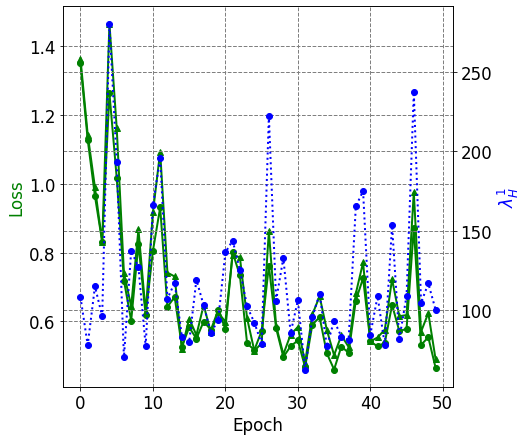

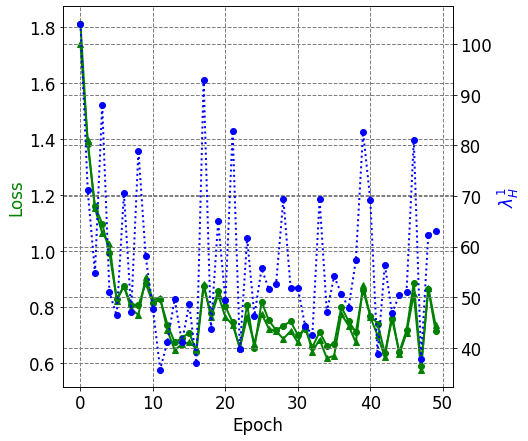

In [ ]:
next_path = os.path.join(root_path, 'corrected')

results_path1 = os.path.join(next_path, '(50ep)hvp_over_minibatch_500/logs')
results_path2 = os.path.join(next_path, 'same_but_vgg/logs')

''' performance
'''
val_wrn = np.loadtxt(os.path.join(results_path1, 'val_loss.txt'), unpack=True).astype(float)
val_vgg = np.loadtxt(os.path.join(results_path2, 'val_loss.txt'), unpack=True).astype(float)

test_wrn = np.loadtxt(os.path.join(results_path1, 'test_loss.txt'), unpack=True).astype(float)
test_vgg = np.loadtxt(os.path.join(results_path2, 'test_loss.txt'), unpack=True).astype(float)

''' curvature and Frob.Norm of HVP
'''
eigen_wrn = np.loadtxt(os.path.join(results_path1, 'top_eigen.txt'), unpack=True).astype(float)
print(np.mean(eigen_wrn), np.std(eigen_wrn))
eigen_vgg = np.loadtxt(os.path.join(results_path2, 'top_eigen.txt'), unpack=True).astype(float)
print(np.mean(eigen_vgg), np.std(eigen_vgg))

frob_wrn = np.loadtxt(os.path.join(results_path1, 'frob_hvp.txt'), unpack=True).astype(float)
frob_vgg = np.loadtxt(os.path.join(results_path2, 'frob_hvp.txt'), unpack=True).astype(float)

''' batch size 
'''
# bs_vgg_noisy = np.loadtxt(os.path.join(results_path3, 'bse.txt'), unpack=True).astype(int)
# bs_wrn_noisy = np.loadtxt(os.path.join(results_path4, 'bse.txt'), unpack=True).astype(int)
# bs_const1 = np.full(200,40) 

''' WRN
'''
fig, ax1 = plt.subplots()
ax1.plot(val_wrn, 'go',linewidth=2, linestyle='-', label='Val. loss')
ax1.plot(test_wrn, 'g^',linewidth=2, linestyle='-', label='Test loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='g')
ax2 = ax1.twinx()
# ax2.set_yticks([0.1,0.02,0.004])
ax2.plot(eigen_wrn, 'bo', linewidth=2, linestyle=':')
ax2.set_ylabel(r'$\lambda_{H}^1$',  color='b')
ax1.grid(color='gray', linewidth=1, linestyle='--')
ax2.grid(color='gray', linewidth=1, linestyle='--')
# ax1.legend('WRN')
# plt.savefig(os.path.join(next_path, 'wrn_curvature.pdf'))

''' VGG
'''
fig, ax1 = plt.subplots()
ax1.plot(val_vgg, 'go',linewidth=2, linestyle='-', label='Val. loss')
ax1.plot(test_vgg, 'g^',linewidth=2, linestyle='-', label='Test loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='g')
ax2 = ax1.twinx()
# ax2.set_yticks([0.1,0.02,0.004])
ax2.plot(eigen_vgg, 'bo', linewidth=2, linestyle=':')
ax2.set_ylabel(r'$\lambda_{H}^1$',  color='b')
ax1.grid(color='gray', linewidth=1, linestyle='--')
ax2.grid(color='gray', linewidth=1, linestyle='--')
# ax1.legend('{VGG}')

''' plot epoch level results (batch size, train/val loss)
'''
# fig, ax1 = plt.subplots()
# ax1.plot(frob_wrn, 'g-')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel(r'$||H||_{D}$', color='g')
# ax2 = ax1.twinx()
# # ax2.set_yticks([0.1,0.02,0.004])
# ax2.plot(eigen_wrn, 'b-', linewidth=2, linestyle='--')
# ax2.set_ylabel(r'$\lambda_{H}^1$',  color='b')
# ax1.grid(color='gray', linewidth=1, linestyle='--')
# ax2.grid(color='gray', linewidth=1, linestyle='--')
# plt.savefig(os.path.join(next_path, 'wrn_curvature.pdf'))




# fig1, ax1 = plt.figure(figsize=(7,7)), plt.gca()
# ax1.plot(val_wrn, color='green', lw=4, label=r'')
# ax1.plot(bs_wrn_noisy , color='blue', lw=4, label=r'')
# ax1.plot(bs_const1, color='blue',lw=4, linestyle='dotted')
# # ax1.plot(bs_vgg_quiet, color='green', lw=4, label=r'')
# # ax1.plot(bs_wrn_quiet , color='blue', lw=4, label=r'')
# # ax1.plot(bs_const2, color='blue',lw=4, linestyle='dotted')
# plt.xlabel('Epoch')
# plt.ylabel('Batch size')
# plt.xlim([-10,200])
# ax1.grid(color='gray', linewidth=1, linestyle='--')
# # plt.savefig(os.path.join(next_path,'dotted_noisy_plots_BatchSize.eps'))

# ''' show both validation and test loss
# '''
# fig2,ax2 = plt.figure(figsize=(7,7)), plt.gca()
# # ax2.plot(test_vgg_noisy_base, color='green', lw=3 , linestyle='dotted',label='VGG')
# # ax2.plot(test_vgg_noisy_arb, color='green', lw=3,  linestyle='-', label='VGG+Arbiter')
# # ax2.plot(test_wrn_noisy_base, color='blue', lw=3, linestyle='dotted' ,label='WRN')
# # ax2.plot(test_wrn_noisy_arb, color='blue', lw=3, linestyle='-',label='WRN+Arbiter')
# ax2.plot(val_vgg_noisy_base, color='green', lw=4 , linestyle='dotted',label='VGG')
# ax2.plot(val_vgg_noisy_arb, color='green', lw=4,  linestyle='-', label='VGG+Arbiter')
# ax2.plot(val_wrn_noisy_base, color='blue', lw=4, linestyle='dotted' ,label='WRN')
# ax2.plot(val_wrn_noisy_arb, color='blue', lw=4, linestyle='-',label='WRN+Arbiter')
# plt.xlabel('Epoch')
# plt.ylabel('Validation loss')
# plt.yscale('log')
# plt.xlim([0,200])
# plt.ylim([0.3,10])
# plt.legend(loc='best')
# ax2.grid(color='gray', which='major',linewidth=1, linestyle='--')
# # plt.savefig(os.path.join(next_path,'dotted_noisy_plots_valLoss_log.eps'))





## Optimal B for different hypers

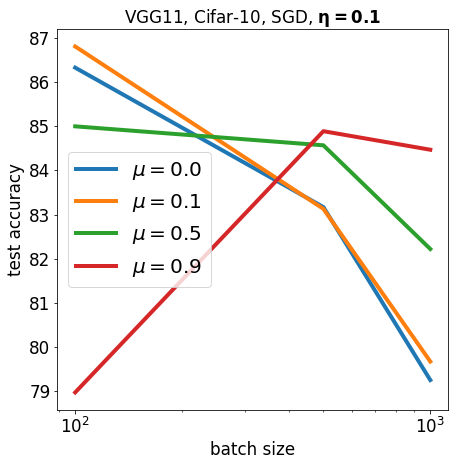

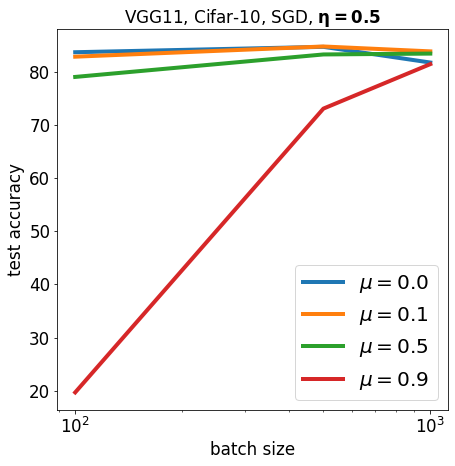

In [21]:
# xaxis 
batch_sizes = np.array([100, 500, 1000])

''' CIFAR-10
'''
# yaxis
test_acc_lr01mu09 = np.array([78.97,84.89,84.47])
test_acc_lr01mu05 = np.array([85.0,84.57,82.22])
test_acc_lr01mu01 = np.array([86.81, 83.13, 79.67])
test_acc_lr01mu00 = np.array([86.33, 83.17, 79.25])

# yaxis
test_acc_lr05mu09 = np.array([19.68, 73.07, 81.44])
test_acc_lr05mu05 = np.array([79.03, 83.26, 83.42])
test_acc_lr05mu01 = np.array([82.84, 84.76, 83.84])
test_acc_lr05mu00 = np.array([83.68, 84.69, 81.74])


fig, ax = plt.figure(), plt.gca()
ax.set_title(r'VGG11, Cifar-10, SGD, $\bf\eta=0.1$')
ax.set_xscale('log')
ax.set_xlabel('batch size')
ax.set_ylabel('test accuracy')
ax.plot(batch_sizes, test_acc_lr01mu00, label=r'$\mu=0.0$')
ax.plot(batch_sizes, test_acc_lr01mu01, label=r'$\mu=0.1$')
ax.plot(batch_sizes, test_acc_lr01mu05, label=r'$\mu=0.5$')
ax.plot(batch_sizes, test_acc_lr01mu09, label=r'$\mu=0.9$')
plt.legend()


fig, ax = plt.figure(), plt.gca()
ax.set_title(r'VGG11, Cifar-10, SGD, $\bf\eta=0.5$')
ax.set_xscale('log')
ax.set_xlabel('batch size')
ax.set_ylabel('test accuracy')
ax.plot(batch_sizes, test_acc_lr05mu00, label=r'$\mu=0.0$')
ax.plot(batch_sizes, test_acc_lr05mu01, label=r'$\mu=0.1$')
ax.plot(batch_sizes, test_acc_lr05mu05, label=r'$\mu=0.5$')
ax.plot(batch_sizes, test_acc_lr05mu09, label=r'$\mu=0.9$')
plt.legend()

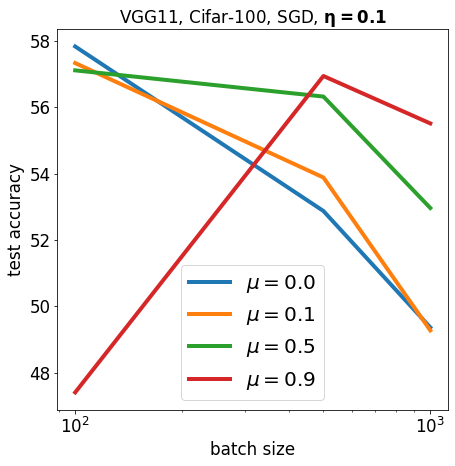

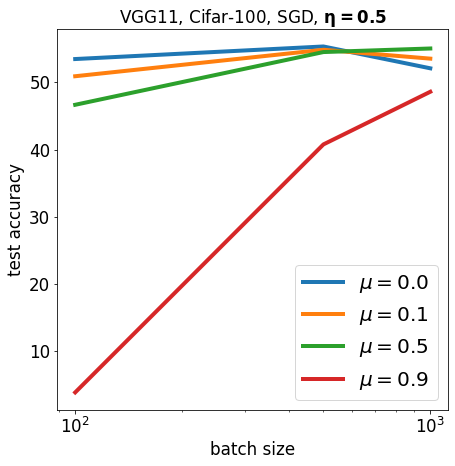

In [20]:

''' CIFAR-100
'''
# yaxis
test_acc_lr01mu09 = np.array([47.4, 56.94, 55.51])
test_acc_lr01mu05 = np.array([57.11, 56.32, 52.96])
test_acc_lr01mu01 = np.array([57.33, 53.88, 49.27])
test_acc_lr01mu00 = np.array([57.83, 52.87, 49.36])

# yaxis
test_acc_lr05mu09 = np.array([3.86, 40.77, 48.61])
test_acc_lr05mu05 = np.array([46.67, 54.52, 55.05])
test_acc_lr05mu01 = np.array([50.92, 54.86, 53.54])
test_acc_lr05mu00 = np.array([53.48, 55.35, 52.1])


fig, ax = plt.figure(), plt.gca()
ax.set_title(r'VGG11, Cifar-100, SGD, $\bf\eta=0.1$')
ax.set_xscale('log')
ax.set_xlabel('batch size')
ax.set_ylabel('test accuracy')
ax.plot(batch_sizes, test_acc_lr01mu00, label=r'$\mu=0.0$')
ax.plot(batch_sizes, test_acc_lr01mu01, label=r'$\mu=0.1$')
ax.plot(batch_sizes, test_acc_lr01mu05, label=r'$\mu=0.5$')
ax.plot(batch_sizes, test_acc_lr01mu09, label=r'$\mu=0.9$')
plt.legend()


fig, ax = plt.figure(), plt.gca()
ax.set_title(r'VGG11, Cifar-100, SGD, $\bf\eta=0.5$')
ax.set_xscale('log')
ax.set_xlabel('batch size')
ax.set_ylabel('test accuracy')
ax.plot(batch_sizes, test_acc_lr05mu00, label=r'$\mu=0.0$')
ax.plot(batch_sizes, test_acc_lr05mu01, label=r'$\mu=0.1$')
ax.plot(batch_sizes, test_acc_lr05mu05, label=r'$\mu=0.5$')
ax.plot(batch_sizes, test_acc_lr05mu09, label=r'$\mu=0.9$')
plt.legend()